<a href="https://colab.research.google.com/github/klaasmeinke/CNNs-exoplanet-cartography/blob/main/Plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this notebook has functions to plot planets in 3d, 2d and in mollweide projection, as well as a function to plot curves

In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Thesis'

import numpy as np
import colorsys # for rainbow colors in plot_fluxes

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.patches as patches
from matplotlib import colors as mcolors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook
plt.style.use('mplstyle.txt') # matplotlib style sheet

Mounted at /content/drive
/content/drive/MyDrive/Thesis


# Load Data Files
this function loads all files that could be needed, so that this doesn't need to be done manually <br>
also made for the other notebooks

In [ ]:
def load_data():
    global surfaces
    global rot_norms
    global points
    global ocean_cosines
    global ocean_coefs
    global norms
    global inclinations
    global coefs
    global faces
    global edges
    global cosines
    global cloudy_pixels
    global cloudy_alphas
    global clouds
    global cloud_fracs
    global axes
    global albedos
    global albedos_bw

    surfaces = np.load('data/surfaces.npy')
    rot_norms = np.load('data/rot_norms.npy')
    points = np.load('data/points.npy')
    ocean_cosines = np.load('data/ocean_cosines.npy')
    ocean_coefs = np.load('data/ocean_coefs.npy')
    norms = np.load('data/norms.npy')
    inclinations = np.load('data/inclinations.npy')
    coefs = np.load('data/fou_coefs.npy')
    faces = np.load('data/faces.npy')
    edges = np.load('data/edges.npy')
    cosines = np.load('data/cosines.npy')
    cloudy_pixels = np.load('data/cloudy_pixels.npy')
    cloudy_alphas = np.load('data/cloudy_alphas.npy')
    clouds = np.load('data/clouds.npy')
    cloud_fracs = np.load('data/cloud_fracs.npy')
    axes = np.load('data/axes.npy')
    albedos = np.load('data/albedos.npy')
    albedos_bw = np.load('data/albedos_bw.npy')

In [ ]:
# this makes sure all necessary variable are present (also in all notebook
# # which load this one)
load_data()

# Visualizing Planets

### Fix Colors

#### Finding rgb values from wavelength values:


In [ ]:
# convert from list of albedos to rgb:
def alb_to_rgb(albedos):
    return np.array([ albedos[1], albedos[3], albedos[4] ])

####Convert colors to the right format
output is a rgb array <br>
possible inputs:
- grayscale list
- list of strings
- flattened rgb color list
- array of wavelength albedo lists (800, 700, 600, 550, 500, 400 nm)
- list of surface types (0 = black/ocean, 1 = sandy, 2 = vegetation OR 0 = black, 1 = white if blackwhite = True)

(floats are treated as albedo values and integers are treated as surface type values so use 1.0 for white and 1 for sandy)

In [ ]:
# The functions
def fix_colors(faces, colors, blackwhite = False):
    if type(colors) == np.ndarray:
        colors = colors.tolist()

    # convert from flattened array to rgbs:
    if len(colors) == 3*len(faces):
        colors = np.reshape(colors, (-1,3)).tolist()

    # converting from different data types:
    for c, i in zip(colors, range(len(colors))):
        # grayscale values:
        if isinstance(c, (np.floating, float)):
            colors[i] = [c,c,c]
        # strings:
        elif isinstance(c, str):
            colors[i] = mcolors.to_rgb(c)
        # surface types:
        elif isinstance(c, (np.integer, int)):
            if blackwhite:
                albedos = np.load('data/albedos_bw.npy')
            else:
                albedos = np.load('data/albedos.npy')
            colors[i] = albedos[colors[i]]

        # wavelength albedos:
        if isinstance(colors[i], (np.ndarray, list)):
            if len(colors[i]) == 6:
                colors[i] = alb_to_rgb(colors[i])

    # correcting values outside of [0,1] (e.g. nn outputs)
    colors = np.array(colors)
    colors[colors > 1] = 1
    colors[colors < 0] = 0

    return colors

### Value Colors:
Converts from values to colors using a color map (this code is ugly but it works)

In [ ]:
def value_colors(values, diverging = False, wl = '', color_max = np.inf):
    if diverging:
        if isinstance(wl, int):
            col_4 = [colorsys.hsv_to_rgb(i, 0.2, 1) \
                for i in np.linspace(0, 0.75, 6)][wl]
            col_3 = [colorsys.hsv_to_rgb(i, 0.8, 0.5) \
                for i in np.linspace(0, 0.75, 6)][wl]

            col_1 = [colorsys.hsv_to_rgb(i+0.5, 0.2, 1) \
                for i in np.linspace(0, 0.75, 6)][wl]
            col_2 = [colorsys.hsv_to_rgb(i+0.5, 0.8, 0.5) \
                for i in np.linspace(0, 0.75, 6)][wl]

            basic_cols = [col_1, col_2, 'black', col_3, col_4]
        else:
            basic_cols = [plt.cm.RdBu(0.2), 'black', plt.cm.RdBu(0.8)]

        cmap = LinearSegmentedColormap.from_list('mycmap', basic_cols)
        # this is needed for the color bar:
        if color_max < 1:
            norm = mcolors.Normalize(-color_max, color_max)
            norm_values = values/color_max
        else:
            norm = mcolors.Normalize(-np.max(np.abs(values)),
                                     np.max(np.abs(values)))
            # force the value to range between 0 and 1 for the cmap function:
            norm_values = 0.5+0.5*values/(np.max(values) + 1e-5)

    else:
        if isinstance(wl, int):
            mid_col = [colorsys.hsv_to_rgb(i, 0.8, 0.5) \
                for i in np.linspace(0, 0.75, 6)][wl]
            basic_cols = ['black', mid_col, 'white']
        else:
            basic_cols = ['black', plt.cm.Blues(0.8), plt.cm.Blues(0.4), 'white']

        cmap = LinearSegmentedColormap.from_list('mycmap', basic_cols)

        if color_max < 100:
            norm = mcolors.Normalize(0, color_max)
            norm_values = values/color_max
        else:
            norm = mcolors.Normalize(0, np.max(np.abs(values)))
            norm_values = values/(np.max(values) + 1e-5)

    colors = cmap(norm_values)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    return sm, colors

NameError: ignored

### 3D Visualization

In [ ]:
def plot_3d(faces, colors, blackwhite = False):
    colors = fix_colors(faces, colors, blackwhite = blackwhite)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()

    for i in range(len(faces)):
        face = a3.art3d.Poly3DCollection([faces[i]])
        face.set_facecolor(colors[i])
        ax.add_collection3d(face)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

#### Test

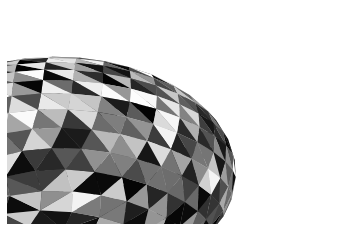

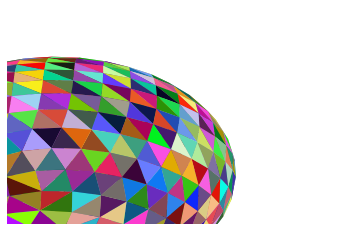

In [ ]:
# # black and white:
# colors = [np.random.rand() for face in faces]
# plot_3d(faces, colors)

# # colored:
# colors = [[np.random.rand() for i in range(3)] for face in faces]
# plot_3d(faces, colors)

### Planetary Disk
for plotting resolved fluxes across the planet <br>
only faces with a center that has a positive x-coordinate are plotted <br>
first convert Faces to Patches for plotting efficiency

In [ ]:
def faces2patches(faces, colors):
    patch_list = []
    for f in faces:
        polygon = Polygon(f)
        patch_list.append(polygon)

    p = PatchCollection(patch_list)
    p.set_facecolor(colors)

    return p

In [ ]:
def plot_disk(faces, colors = [], values = [], diverging = True,
              blackwhite = False, wl = '', colorbar = True, color_max = np.inf):

    if list(colors):
        #convert from different color formats:
        colors = fix_colors(faces, colors, blackwhite = blackwhite)
        # create plot:
        fig, ax1 = plt.subplots(figsize = (4,4))

    else: # create colors from values
        if not list(values):
            raise ValueError('either enter colors or values')

        sm, colors = value_colors(values, diverging = diverging, wl = wl,
                                  color_max = color_max)
        # create plot:
        if colorbar:
            fig = plt.figure(figsize = (5.33, 4))
            gs = fig.add_gridspec(4,4)
            ax1 = fig.add_subplot(gs[:, :3])
            ax2 = fig.add_subplot(gs[:, 3])
            ax2.axis('off')
            # add color bar:
            fig.colorbar(sm, ax = ax2)
        else:
            fig, ax1 = plt.subplots(figsize = (4,4))

    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax1.axis('off')
    fig.set_facecolor('white')

    # make lists of faces and colors that should be plotted (x of center of face is > 0)
    plot_faces = []
    plot_colors = []

    for f, c in zip(faces, colors):
        if np.mean(f[:,0]) > 0: # x of center of face > 0
            plot_faces.append(f[:,1:])
            plot_colors.append(c)

    # add patches:
    patch_list = faces2patches(plot_faces, plot_colors)
    ax1.add_collection(patch_list)

    # add border (to make it perfectly circular)
    circ1 = patches.Arc((0,0), 2, 2, fill = 0, edgecolor = 'white', linewidth = 1)
    circ2 = patches.Arc((0,0), 1.98, 1.98, fill = 0, edgecolor = 'black', linewidth = 1)
    ax1.add_patch(circ1)
    ax1.add_patch(circ2)

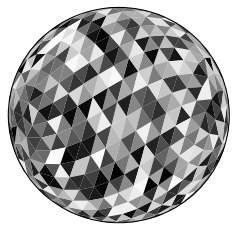

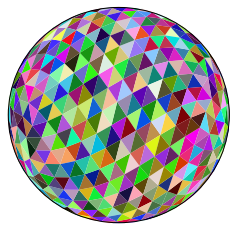

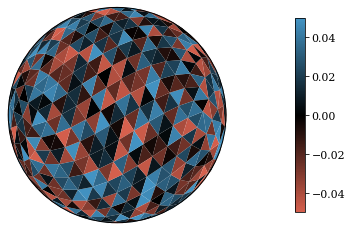

0


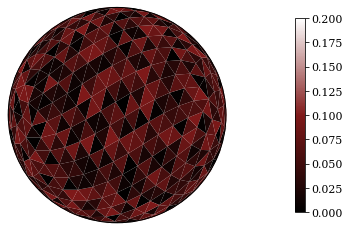

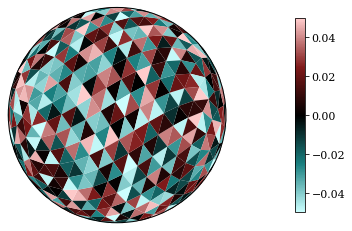

1


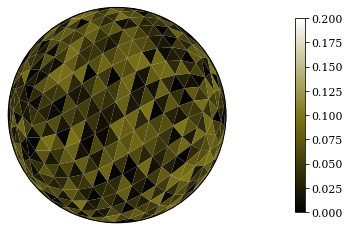

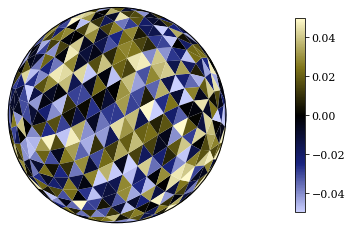

2


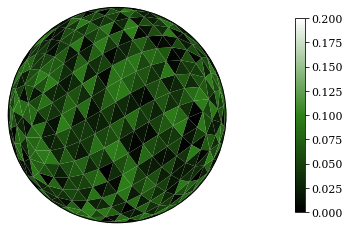

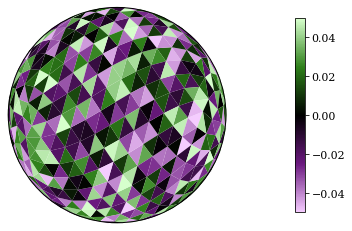

3


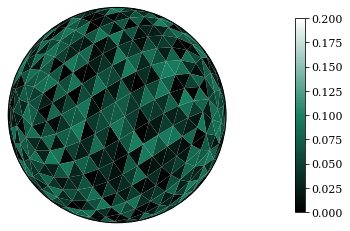

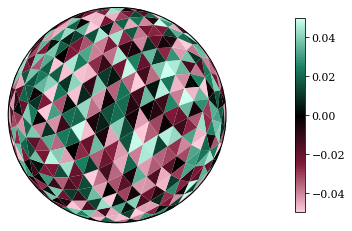

4


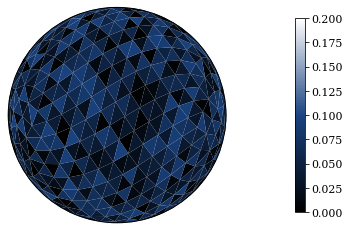

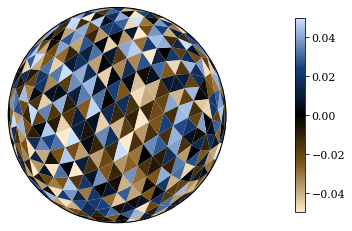

5


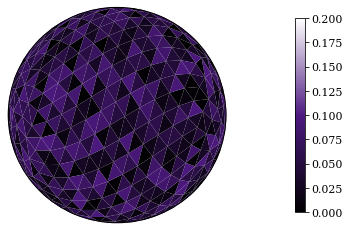

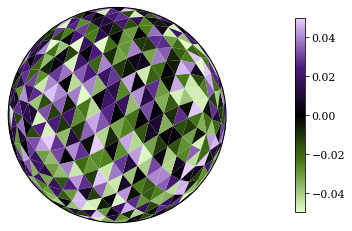

In [ ]:
# # black and white:
# colors = [np.random.rand() for face in faces]
# plot_disk(faces, colors = colors)

# # colored:
# colors = [[np.random.rand() for i in range(3)] for face in faces]
# plot_disk(faces, colors)

# # diverging plot (used for polarization plots)
# values = 0.1*np.random.rand(1000)-0.05
# plot_disk(faces, values = values, diverging = True)
# plt.show()

# # non-diverging plot
# for wl in range(6):
#     values = 0.1*np.random.rand(1000)
#     print(wl)
#     plot_disk(faces, values = values, diverging = False, wl = wl, colorbar = True,
#               color_max = 0.2)
#     plot_disk(faces, values = values - 0.05, diverging = True, wl = wl)
#     plt.show()

### Geodetic Map
#### Split Faces at Poles
split the faces at the poles to minize distortion:

In [ ]:
# this function turns a list of triangles into a list 4x as long, where each triangle has been split in 4
def quadruple(faces):
    new_faces = []
    for face in faces:
        new_faces.append([face[0],(face[0]+face[1])/2, (face[0]+face[2])/2])
        new_faces.append([face[1],(face[1]+face[0])/2, (face[1]+face[2])/2])
        new_faces.append([face[2],(face[2]+face[0])/2, (face[2]+face[1])/2])
        new_faces.append([(face[0]+face[1])/2,(face[0]+face[2])/2, (face[1]+face[2])/2])

    new_faces = np.array(new_faces)

    for j in range(len(new_faces)):
        for k in range(3):
            new_faces[j,k] /= np.linalg.norm(new_faces[j,k])

    return new_faces

# quadruples triangles at poles to minimize distortion:
def split_poles(faces, colors):
    for i in range(len(faces)):
        idx = []

        if np.min(faces[i,:,2]) < -0.8 or np.max(faces[i,:,2]) > 0.8:
            idx.append(i) # to delete these faces later as they have now been replaced
            new_faces = quadruple([faces[i]])
            if np.min(faces[i,:,2]) < -0.9 or np.max(faces[i,:,2]) > 0.9:
                new_faces = quadruple(new_faces)
            faces = np.append(faces, new_faces, axis = 0)
            colors = np.append(colors, [colors[i] for j in range(len(new_faces))], axis = 0)

    colors = np.delete(colors, idx, 0)
    faces = np.delete(faces, idx, 0)

    return faces, colors

#### Convert from Cartesian to Geodetic
convert a list of faces from cartesian to geodetic and double them on the borders of the map (long = +- pi):

In [ ]:
# cartesian to geodetic
def cart2geo(x, y, z):
    lat = np.arcsin(z / 1) # radius = 1
    lon = np.arctan2(y, x)
    return(np.array([lon,lat]))

# geodetic to cartesian
def geo2cart(lon,lat):
    # r = 1
    x = 1 * np.cos(lat) * np.cos(lon)
    y = 1 * np.cos(lat) * np.sin(lon)
    z = 1 * np.sin(lat)
    return([x,y,z])

def faces2geo(faces, colors):
    faces_geo = []
    colors_geo = []
    for i in range(len(faces)):
        f_geo = []
        for p in faces[i]:
            f_geo.append(cart2geo(p[0],p[1],p[2]))
        f_geo = np.array(f_geo)

        if max(f_geo[:,0]) - min(f_geo[:,0]) < 1.5*np.pi: # testing if it passes through long = pi
            faces_geo.append(f_geo)
            colors_geo.append(colors[i])
        else:
            for p in f_geo:
                if p[0] > 0:
                    p[0] -= 2*np.pi
            faces_geo.append(f_geo)
            faces_geo.append(f_geo + len(faces[0]) * [[2*np.pi,0]])
            colors_geo += 2 * [colors[i]]

    return np.array(faces_geo), np.array(colors_geo)

#### Create Map

In [ ]:
def plot_2d(faces, colors, blackwhite = False):
    #convert from different color formats:
    colors = fix_colors(faces, colors, blackwhite = blackwhite)

    if len(faces[0]) == 3: # check if these are triangles
        # split the poles to minimize distortion:
        faces, colors = split_poles(faces, colors)

    # convert from cartesian to geodetic:
    faces, colors = faces2geo(faces, colors)

    # plot:
    faces[:,:,1] *= 1.02 # so that the poles which are fucked dont show
    fig, ax = plt.subplots(figsize = (6,3))
    fig.set_facecolor('white')

    plt.xlim([-np.pi,np.pi])
    plt.ylim([-np.pi/2,np.pi/2])

    plt.xticks(np.linspace(-np.pi, np.pi, 5),
               ['$-\pi$', '$-\pi$/2', '0', '$\pi$/2', '$\pi$'] )
    plt.yticks(np.linspace(-np.pi/2, np.pi/2, 3),
            ['$-\pi$/2', '0', '$\pi$/2'] )

    plt.ylabel('lattitude [rad]')
    plt.xlabel('longitude [rad]')

    # add patches:
    patches = faces2patches(faces, colors)
    ax.add_collection(patches)

#### Test

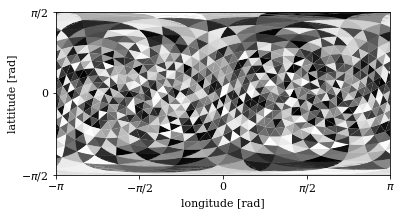

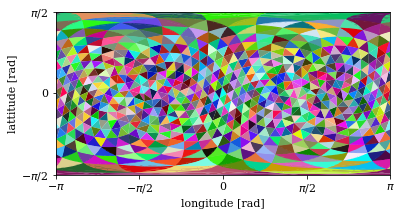

In [ ]:
# # black and white:
# colors = [np.random.rand() for face in faces]
# plot_2d(faces, colors)

# # colored:
# colors = [[np.random.rand() for i in range(3)] for face in faces]
# plot_2d(faces, colors)

### Mollweide Map:

#### Convert from geodetic to mollweide:

In [ ]:
# geodetic to mollweide
def geo2moll(long, lat):
    if lat == np.pi/2:
        x = 0
        y = 2**0.5
    elif lat == -np.pi/2:
        x = 0
        y = -2**0.5
    else:
        theta = lat # start iterations here
        theta_diff = 1 # place holder to start while loop
        while abs(theta_diff) > 1e-6:
            theta_diff = (2*theta + np.sin(2*theta) - np.pi*np.sin(lat))/(2 + 2*np.cos(2*theta))
            theta -= theta_diff
        x = 2 * 2**0.5 /np.pi * long * np.cos(theta)
        y = 2**0.5 * np.sin(theta)
    return x,y

# converts from list of geo faces to list of moll faces
def faces2moll(faces):

    for i in range(len(faces)):
        for j in range(len(faces[i])):
            faces[i,j] = geo2moll(faces[i,j,0],faces[i,j,1])

    return faces

#### Create a border around the map:
returns a list of patches that acts as a border for a mollweide projection <br>
R is taken to be one (but this can be easily changed)

In [ ]:
def moll_border():
    w = 4*2**0.5
    h = 2*2**0.5

    border0 = patches.Arc((0,0), 1.1*w, 1.1*h, fill = 0, edgecolor = 'white', linewidth = 20)
    border1 = patches.Arc((0,0), 1.022*w, 1.035*h, fill = 0, edgecolor = 'white', linewidth = 8)
    border2 = patches.Arc((0,0), w, h, fill = 0, edgecolor = 'black', linewidth = 1)

    return [border0, border1, border2]

#### Create Map:

In [ ]:
def mollweide(faces, colors, blackwhite = False):
    #convert from different color formats:
    colors = fix_colors(faces, colors, blackwhite = blackwhite)

    if len(faces[0]) == 3: # check if these are triangles
        # split the poles to minimize distortion:
        faces, colors = split_poles(faces, colors)

    # convert from cartesian to geodetic:
    faces, colors = faces2geo(faces, colors)

    # convert from geodetic to mollweide:
    faces = faces2moll(faces)

    # plot:
    fig, ax = plt.subplots(figsize = (8,4))
    fig.set_facecolor('white')

    plt.xlim([-3,3])
    plt.ylim([-1.5,1.5])

    plt.axis('off')

    # add patches:
    patches = faces2patches(faces, colors)
    ax.add_collection(patches)

    # add the border:
    for patch in moll_border():
        ax.add_patch(patch)

#### Test

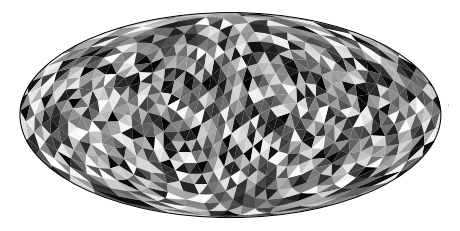

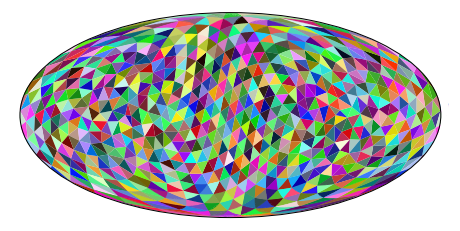

In [ ]:
# # black and white:
# colors = [np.random.rand() for face in faces]
# mollweide(faces, colors)

# # colored:
# colors = [[np.random.rand() for i in range(3)] for face in faces]
# mollweide(faces, colors)

# Plotting Fluxes
this function can plot flux curves
different types of inputs that can be handled:
- three dimensional (dims: 0 orbit positions, 1 rot phases, 2 wavelengths)
- two dimensional (dims = 0 orbit positions, 1 rot phases) (add gaps = True if you want a curve with gaps)
- one dimensional
- x series, labels for legend, xlabel, ylabel and marker ('x', 'o' etc.) are all args that can be included.
- If gaps = True is entered the -2 dimension is put in series rather than on top of eachother
- If rb_colors = True is entered, the colors are taken from the rainbow spectrum (red first and violet last)

In [ ]:
def plot_fluxes(flux_curves, labels = [], colors = [], rb_colors = False,
                gaps = False, marker = '', ylabel = '', xlabel = '', xs = [],
                figsize = (10,5), legend = True, xticks = [],
                new_fig = True, linestyle = 'solid',
                legend_loc = 'center left', legend_y = 0.5, dpi = 150):

    if new_fig:
        fig = plt.figure(figsize = figsize, dpi = dpi)
        fig.set_facecolor('white')
        ax = plt.subplot(111)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

    flux_curves = np.array(flux_curves) # fix data format

    # LINE COLORS
    if not colors:
        if rb_colors or flux_curves.ndim == 3: # rainbow colors
            colors = [colorsys.hsv_to_rgb(i, 1, 0.75) \
                for i in np.linspace(0, 0.75, flux_curves.shape[-1])]
            if not labels:
                labels = [str(w) + ' nm' for w in [800,700,600,550,500,400]]
        else:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # LABELS:
    if not labels:
        labels = ['Epoch ' + str(i+1) for i in range(len(flux_curves))]

    # PLOTTING
    if gaps or flux_curves.ndim == 3: # if there are three axes, gaps are standard
        # fix the data format so it works
        if flux_curves.ndim == 2:
            flux_curves = np.array([[[i] for i in j] for j in flux_curves])
        fmin = np.min(flux_curves)
        fmax = np.max(flux_curves)
        fdev = fmax - fmin
        plt.ylim([fmin -0.04*fdev, fmax + 0.04*fdev])

        for i in range(len(flux_curves)): # iterate over orbit positions
            xs = np.linspace(i+0.1, i+0.9, len(flux_curves[i]))
            for j in range(flux_curves.shape[2]): # iterate over wavelengths

                if i == 0:
                    plt.plot(xs, flux_curves[i,:,j], color = colors[j],
                             label = labels[j], marker = marker,
                             linestyle = linestyle)
                else:
                    plt.plot(xs, flux_curves[i,:,j], color = colors[j],
                             marker = marker, linestyle = linestyle)

        # add a legend:
        if flux_curves.shape[-1] > 1 and legend and new_fig:
            legend0 = plt.legend(loc = legend_loc,
                                 bbox_to_anchor=(1, legend_y))
            plt.gca().add_artist(legend0)

        # the x-axis
        if new_fig:
            plt.xticks(ticks = [i + 0.5 for i in range(len(flux_curves))],
                       labels = [str(i + 1) for i in range(len(flux_curves))])
            ax.xaxis.set_tick_params(length = 0)
            plt.xlabel('Observation Epoch')

    else: # if there aren't gaps
        if rb_colors and flux_curves.ndim == 2:
            flux_curves = np.transpose(flux_curves)

        if not list(xs): # np arrays cant be interpreted as boolean
            xs = np.linspace(0, 360, flux_curves.shape[-1], endpoint = False)
            plt.xlim([-10, 370 - 360/flux_curves.shape[-1] ])
            if flux_curves.shape[-1] <= 10:
                plt.xticks(ticks = np.linspace(0, 360, flux_curves.shape[-1],
                                               endpoint = False))
        if new_fig:
            if not xlabel:
                xlabel = 'Rotation Phase [deg]'
            plt.xlabel(xlabel)

        if list(xticks):
            plt.xticks(ticks = xticks)

        if flux_curves.ndim == 2: # plotting several lines without gaps
            if len(labels) != len(flux_curves):
                print('labels: ', labels)
                print('flux_curves shape: ', np.shape(flux_curves))
                raise ValueError("number of curves and labels in plot_fluxes is not same")
            for fs, label, color in zip(flux_curves, labels, colors):
                plt.plot(xs, fs, label = label, marker = marker,
                         color = color, linestyle = linestyle)
            if legend and new_fig:
                legend0 = plt.legend(loc = legend_loc,
                                     bbox_to_anchor=(1, legend_y))
                plt.gca().add_artist(legend0)

        elif flux_curves.ndim == 1: # if there is only one curve
            plt.plot(xs, flux_curves, marker = marker, color = colors[0],
                     linestyle = linestyle)
        else:
            raise ValueError('array has too many dimensions (max. 3)')

    if not ylabel:
        ylabel = 'Flux'
    plt.ylabel(ylabel)

#### A Function for Adding an Extra Legend:

In [ ]:
from matplotlib.lines import Line2D

def add_legend(linestyles = ['solid', 'dotted'],
               labels = ['Planet 1', 'Planet 2'],
               x = 1, y = 0.8, loc = 'center left'):

    if len(linestyles) != len(labels):
        raise ValueError('Number of linestyles not equal to number of labels')

    custom_lines = [Line2D([0], [0], color='black', linestyle = ls)
                    for ls in linestyles]

    legend1 = plt.legend(custom_lines, labels, bbox_to_anchor=(x, y),
                         loc = loc)

    plt.gca().add_artist(legend1)

#### Testing

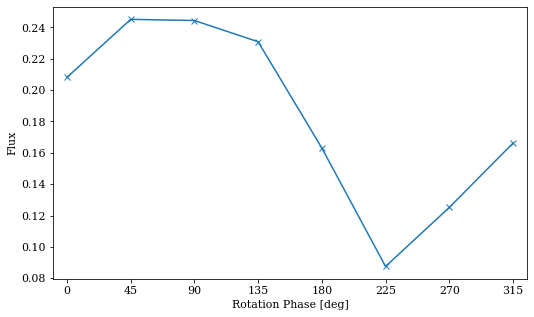

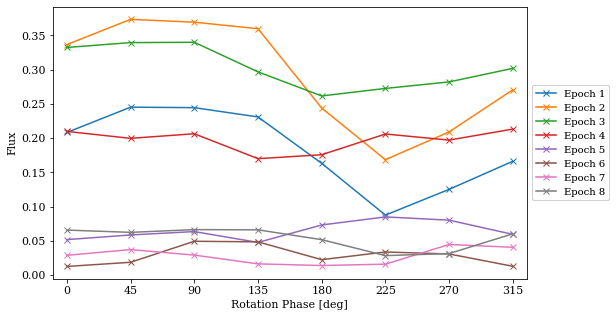

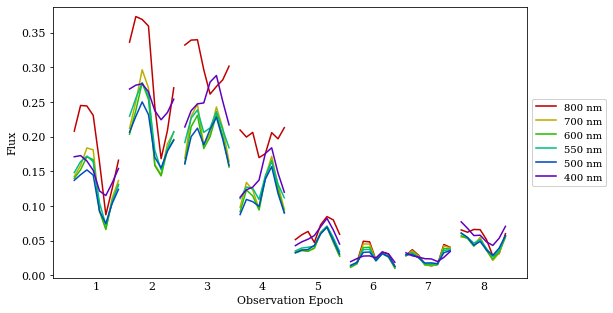

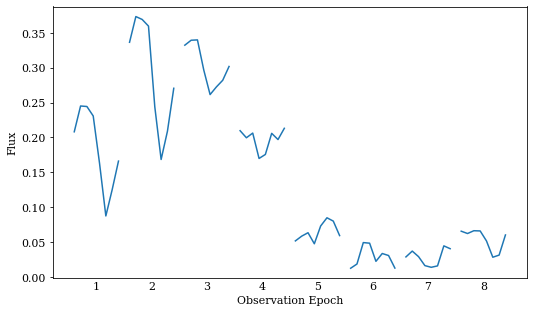

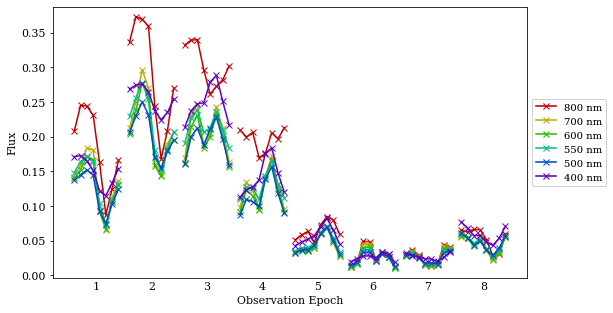

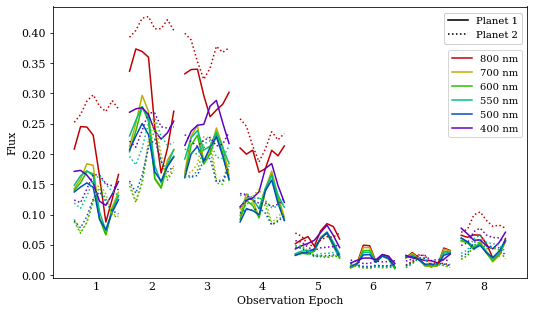

In [ ]:
# # # dims: 0 planet, 1 position, 2 rotation phase, 3 wavelengths, 4 stokes [i,q,u]
# curves = np.load('data/fou_curves/fou_curves_i0.npy')

# planet = 0

# plot_fluxes(curves[planet, 0, :, 0, 0], marker = 'x')
# plot_fluxes(curves[planet, :, :, 0, 0], marker = 'x')
# plot_fluxes(curves[planet, :, :, :, 0], rb_colors = True)
# plot_fluxes(curves[planet, :, :, 0, 0], gaps = True)
# plot_fluxes(curves[planet, :, :, :, 0], marker = 'x')

# # two in one
# plot_fluxes(curves[planet, :, :, :, 0], legend_loc = 'lower right')
# plot_fluxes(curves[planet + 1, :, :, :, 0], new_fig = False,
#             linestyle = 'dotted')

# add_legend(loc = 'center right', y = 0.92)